In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-277217555.py:23: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_df.pct_change().dropna()


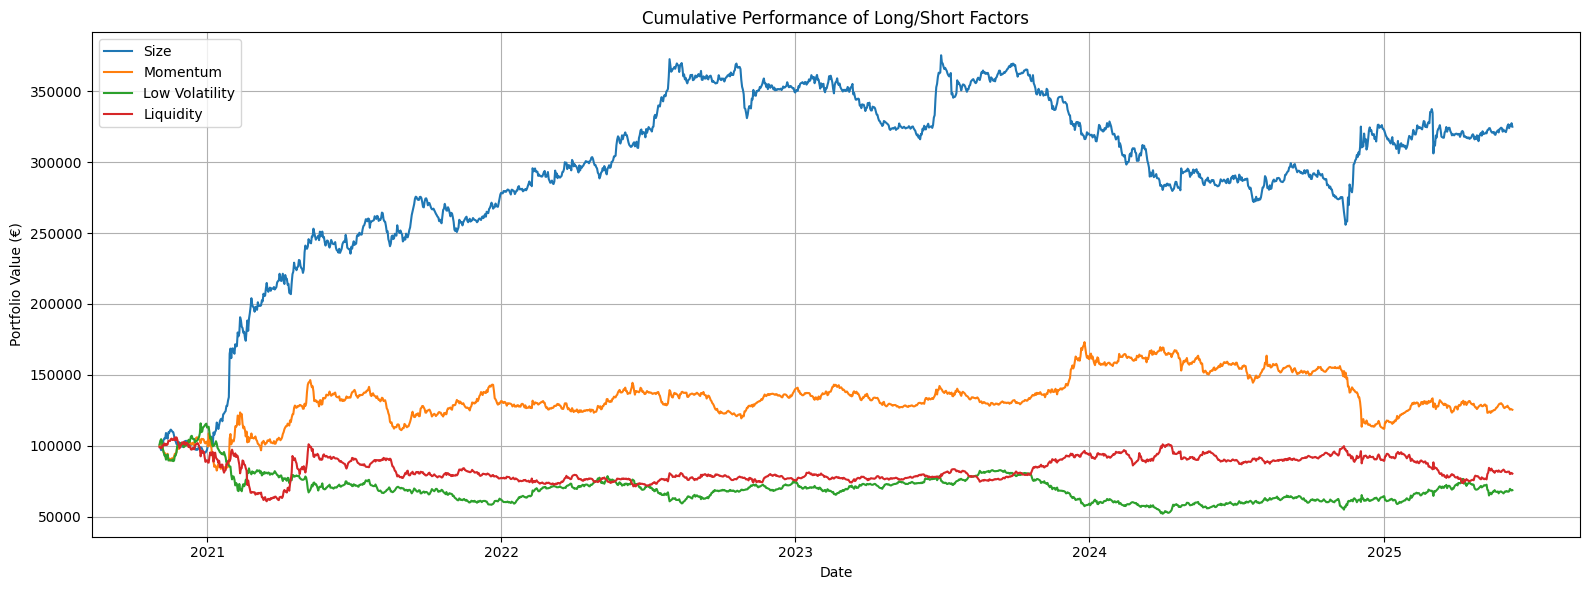


📊 Individual Factor Performance:

🔹 Size Factor:
Initial Capital                  100,000 €
Final Capital                    324,949 €
Total Return                      224.95 %
Annual Return (APY)                29.20 %
Annual Volatility                  22.96 %
Sharpe Ratio                          1.14
Sortino Ratio                         2.07
Max Drawdown                      -31.84 %
Start Date             2020-11-03 00:00:00
End Date               2025-06-09 00:00:00
Days                                  1679
dtype: object
------------------------------------------------------------
🔹 Momentum Factor:
Initial Capital                  100,000 €
Final Capital                    125,385 €
Total Return                       25.39 %
Annual Return (APY)                 5.04 %
Annual Volatility                  25.89 %
Sharpe Ratio                          0.24
Sortino Ratio                         0.34
Max Drawdown                      -35.29 %
Start Date             2020-11-03 00:00

In [112]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load local data
def load_local_data(folder_path):
    price_df = pd.DataFrame()
    mcap_df = pd.DataFrame()
    volume_df = pd.DataFrame()

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            symbol = file.split('-')[0].lower()
            df = pd.read_csv(os.path.join(folder_path, file))
            df['date'] = pd.to_datetime(df['snapped_at']).dt.tz_localize(None)
            df = df.set_index('date').sort_index()

            price_df[symbol] = df['price']
            mcap_df[symbol] = df['market_cap']
            volume_df[symbol] = df['total_volume']

    returns = price_df.pct_change().dropna()
    volatility = returns.rolling(30).std()
    for df in [returns, price_df, mcap_df, volume_df, volatility]:
        df.index = df.index.tz_localize(None)


    return returns, price_df, mcap_df, volume_df, volatility

# 2. Size Factor
def compute_size_factor_mcap(returns, market_cap, signal_window, backtest_window, quantile=0.3):
    size_factor = pd.Series(dtype=float, index=returns.index)
    for start in range(0, len(returns), backtest_window):
        sig_end = start + signal_window
        bt_end = sig_end + backtest_window
        if bt_end > len(returns): break

        dates_signal = returns.index[start:sig_end]
        dates_back = returns.index[sig_end:bt_end]
        mcap_avg = market_cap.loc[dates_signal].mean()
        inv_mcap = 1.0 / mcap_avg.replace(0, np.nan).dropna()
        if inv_mcap.empty: continue

        q_top = inv_mcap.quantile(1 - quantile)
        q_bot = inv_mcap.quantile(quantile)
        small_caps = inv_mcap[inv_mcap >= q_top].index
        large_caps = inv_mcap[inv_mcap <= q_bot].index
        if len(small_caps) == 0 and len(large_caps) == 0:
            continue

        w = pd.Series(0.0, index=returns.columns)
        w[small_caps] = 1.0 / (2 * len(small_caps))
        w[large_caps] = -1.0 / (2 * len(large_caps))
        rets = returns.loc[dates_back].dropna(how='all', axis=1)
        daily_returns = rets[w.index].dot(w).dropna()
        size_factor.loc[daily_returns.index] = daily_returns
    return size_factor.rename("SizeFactor")

# 3. Momentum Factor
def compute_momentum_factor(returns: pd.DataFrame, signal_window: int, backtest_window: int, quantile: float = 0.3):
    n_days = len(returns)
    momentum_portfolio = pd.Series(dtype=float, index=returns.index)

    for start in range(0, n_days, backtest_window):
        sig_end = start + signal_window
        bt_end = sig_end + backtest_window
        if bt_end > n_days:
            break

        dates_signal = returns.index[start:sig_end]
        date_signal = dates_signal[-1]
        dates_back = returns.index[sig_end:bt_end]

        returns_window = returns.loc[dates_signal]
        cum_returns = (returns_window + 1).prod() - 1
        std = returns_window.std()
        sharpe_like = cum_returns / std.replace(0, np.nan)

        z_cum = (cum_returns - cum_returns.mean()) / cum_returns.std()
        z_sharpe = (sharpe_like - sharpe_like.mean()) / sharpe_like.std()

        momentum_score = 0.5 * (z_cum + z_sharpe)
        momentum_score = momentum_score.dropna()
        if momentum_score.empty:
            continue

        q_top = momentum_score.quantile(1 - quantile)
        q_bot = momentum_score.quantile(quantile)

        long_assets = momentum_score[momentum_score >= q_top].index
        short_assets = momentum_score[momentum_score <= q_bot].index

        if len(long_assets) == 0 and len(short_assets) == 0:
            continue

        w = pd.Series(0.0, index=returns.columns)
        if len(long_assets) > 0:
            w[long_assets] = 1.0 / (2 * len(long_assets))
        if len(short_assets) > 0:
            w[short_assets] = -1.0 / (2 * len(short_assets))

        rets = returns.loc[dates_back].dropna(how='all', axis=1)
        rets = rets.loc[:, rets.columns.isin(w.index)]
        daily_returns = rets.dot(w).dropna()
        momentum_portfolio.loc[daily_returns.index] = daily_returns

    return momentum_portfolio.rename("MomentumFactor")


# 4. Low Volatility Factor
def compute_low_volatility_factor(returns, signal_window, backtest_window, quantile=0.3):
    low_vol = pd.Series(dtype=float, index=returns.index)
    for start in range(0, len(returns), backtest_window):
        sig_end = start + signal_window
        bt_end = sig_end + backtest_window
        if bt_end > len(returns): break

        dates_signal = returns.index[start:sig_end]
        dates_back = returns.index[sig_end:bt_end]
        vol = returns.loc[dates_signal].std()

        low_vol_assets = vol[vol <= vol.quantile(quantile)].index
        high_vol_assets = vol[vol >= vol.quantile(1 - quantile)].index
        if len(low_vol_assets) == 0 and len(high_vol_assets) == 0:
            continue

        w = pd.Series(0.0, index=returns.columns)
        w[low_vol_assets] = 1.0 / (2 * len(low_vol_assets))
        w[high_vol_assets] = -1.0 / (2 * len(high_vol_assets))
        rets = returns.loc[dates_back].dropna(how='all', axis=1)
        daily_returns = rets[w.index].dot(w).dropna()
        low_vol.loc[daily_returns.index] = daily_returns
    return low_vol.rename("LowVolFactor")

# 5. Liquidity Factor (Turnover-based, long/short)
def compute_liquidity_factor(volume: pd.DataFrame, market_cap: pd.DataFrame, returns: pd.DataFrame,
                             signal_window: int, backtest_window: int, quantile: float = 0.3):
    n_days = len(returns)
    liquidity_factor = pd.Series(dtype=float, index=returns.index)

    for start in range(0, n_days, backtest_window):
        sig_end = start + signal_window
        bt_end = sig_end + backtest_window
        if bt_end > n_days:
            break

        date_signal = returns.index[sig_end - 1]
        dates_back = returns.index[sig_end:bt_end]

        vol = volume.loc[volume.index <= date_signal].iloc[-signal_window:]
        mcap = market_cap.loc[market_cap.index <= date_signal].iloc[-signal_window:]

        turnover = vol / mcap
        avg_turnover = turnover.mean()
        liquidity_score = avg_turnover.dropna()

        if liquidity_score.empty:
            continue

        q_top = liquidity_score.quantile(1 - quantile)
        q_bot = liquidity_score.quantile(quantile)
        long_assets = liquidity_score[liquidity_score >= q_top].index
        short_assets = liquidity_score[liquidity_score <= q_bot].index

        if len(long_assets) == 0 and len(short_assets) == 0:
            continue

        w = pd.Series(0.0, index=returns.columns)
        if len(long_assets) > 0:
            w[long_assets] = 1.0 / (2 * len(long_assets))
        if len(short_assets) > 0:
            w[short_assets] = -1.0 / (2 * len(short_assets))

        rets = returns.loc[dates_back, returns.columns.intersection(w.index)].dropna(how='all', axis=1)
        daily_ret = rets.dot(w).dropna()
        liquidity_factor.loc[daily_ret.index] = daily_ret

    return liquidity_factor.rename("LiquidityFactor")

# 6. Plot cumulative performance
def plot_all_factors(factor_returns_dict, initial_capital=100_000):
    plt.figure(figsize=(16, 6))
    for name, series in factor_returns_dict.items():
        cum = (1 + series).dropna().cumprod() * initial_capital
        plt.plot(cum, label=name)
    plt.title("Cumulative Performance of Long/Short Factors")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (€)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 7. Performance metrics
def compute_performance_metrics(portfolio_returns, initial_capital=100_000, risk_free_rate=0.02):
    portfolio_returns = portfolio_returns.dropna()
    cum_curve = (1 + portfolio_returns).cumprod() * initial_capital
    total_days = (portfolio_returns.index[-1] - portfolio_returns.index[0]).days
    ann_return = (cum_curve.iloc[-1] / initial_capital) ** (365 / total_days) - 1
    ann_vol = portfolio_returns.std() * np.sqrt(365)
    excess_daily = portfolio_returns - risk_free_rate / 365
    sharpe = excess_daily.mean() / excess_daily.std() * np.sqrt(365)
    downside_std = portfolio_returns[portfolio_returns < 0].std()
    sortino = excess_daily.mean() / downside_std * np.sqrt(365) if downside_std > 0 else np.nan
    peak = cum_curve.cummax()
    drawdown = cum_curve / peak - 1
    max_dd = drawdown.min()

    return pd.Series({
        "Initial Capital": f"{initial_capital:,.0f} €",
        "Final Capital": f"{cum_curve.iloc[-1]:,.0f} €",
        "Total Return": f"{(cum_curve.iloc[-1]/initial_capital - 1)*100:.2f} %",
        "Annual Return (APY)": f"{ann_return*100:.2f} %",
        "Annual Volatility": f"{ann_vol*100:.2f} %",
        "Sharpe Ratio": round(sharpe, 2),
        "Sortino Ratio": round(sortino, 2),
        "Max Drawdown": f"{max_dd*100:.2f} %",
        "Start Date": portfolio_returns.index[0],
        "End Date": portfolio_returns.index[-1],
        "Days": total_days
    })

# 🔁 Main execution
folder_path = "/content/drive/Shareddrives/Sixteen01-2025/Top 10 coins"
signal_window = 30
backtest_window = 30

returns, price, market_cap, volume, volatility = load_local_data(folder_path)

common_index = returns.index.intersection(price.index).intersection(market_cap.index).intersection(volume.index)
returns = returns.loc[common_index]
price = price.loc[common_index]
market_cap = market_cap.loc[common_index]
volume = volume.loc[common_index]
volatility = volatility.loc[common_index]


# Compute factors
size_factor = compute_size_factor_mcap(returns, market_cap, signal_window, backtest_window)
momentum_factor = compute_momentum_factor(returns, signal_window, backtest_window)
low_vol_factor = compute_low_volatility_factor(returns, signal_window, backtest_window)
liquidity_factor = compute_liquidity_factor(volume, market_cap, returns, signal_window, backtest_window)

# Dictionary of all factors
factors = {
    "Size": size_factor,
    "Momentum": momentum_factor,
    "Low Volatility": low_vol_factor,
    "Liquidity": liquidity_factor
}

# Plot all cumulative performances
plot_all_factors(factors)

# Print individual metrics
print("\n📊 Individual Factor Performance:\n")
for name, factor_series in factors.items():
    print(f"🔹 {name} Factor:")
    print(compute_performance_metrics(factor_series))
    print("-" * 60)


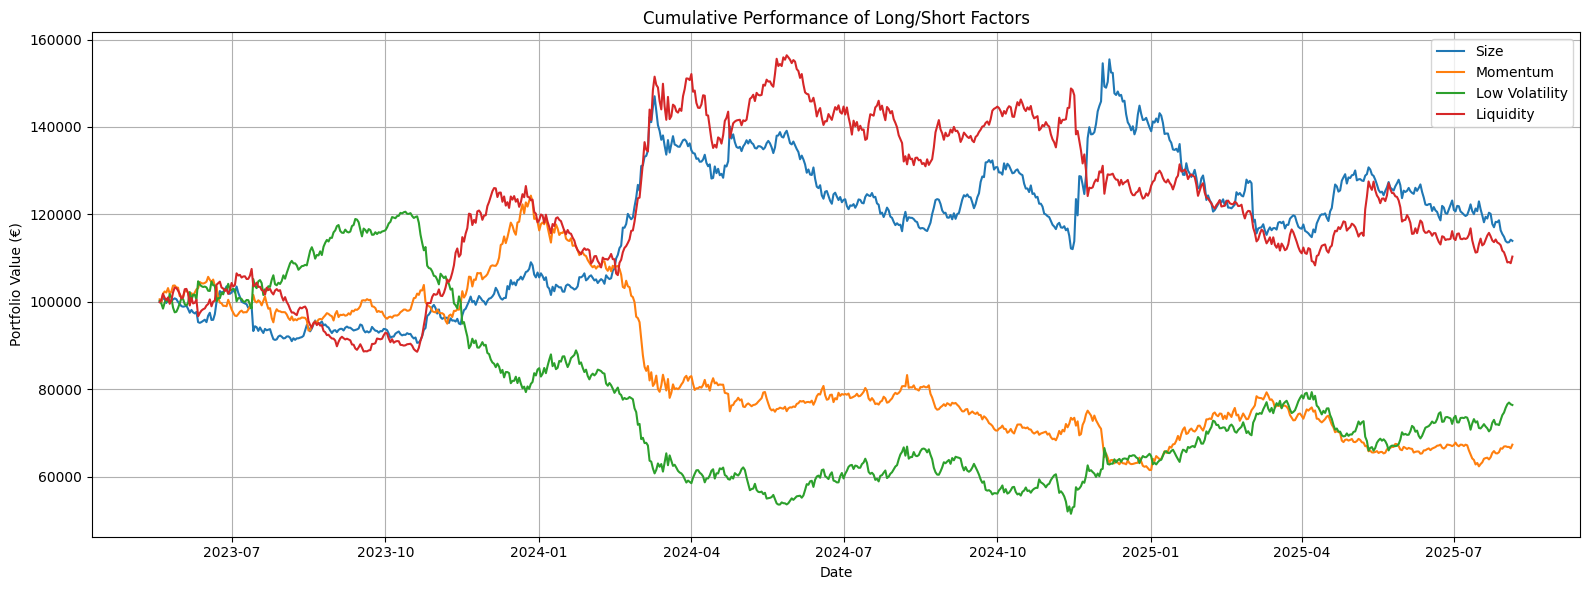


📊 Individual Factor Performance:

🔹 Size Factor:
Initial Capital                  100,000 €
Final Capital                    113,934 €
Total Return                       13.93 %
Annual Return (APY)                 6.06 %
Annual Volatility                  22.71 %
Sharpe Ratio                          0.28
Sortino Ratio                         0.47
Max Drawdown                      -26.95 %
Start Date             2023-05-19 00:00:00
End Date               2025-08-05 00:00:00
Days                                   809
dtype: object
------------------------------------------------------------
🔹 Momentum Factor:
Initial Capital                  100,000 €
Final Capital                     67,308 €
Total Return                      -32.69 %
Annual Return (APY)               -16.36 %
Annual Volatility                  21.45 %
Sharpe Ratio                         -0.82
Sortino Ratio                        -1.05
Max Drawdown                      -50.52 %
Start Date             2023-05-19 00:00

In [114]:
# 🔁 Main execution
folder_path = "/content/drive/Shareddrives/Sixteen01-2025/Data Factor Portfolio"
signal_window = 30
backtest_window = 30

returns, price, market_cap, volume, volatility = load_local_data(folder_path)

common_index = returns.index.intersection(price.index).intersection(market_cap.index).intersection(volume.index)
returns = returns.loc[common_index]
price = price.loc[common_index]
market_cap = market_cap.loc[common_index]
volume = volume.loc[common_index]
volatility = volatility.loc[common_index]


# Compute factors
size_factor = compute_size_factor_mcap(returns, market_cap, signal_window, backtest_window)
momentum_factor = compute_momentum_factor(returns, signal_window, backtest_window)
low_vol_factor = compute_low_volatility_factor(returns, signal_window, backtest_window)
liquidity_factor = compute_liquidity_factor(volume, market_cap, returns, signal_window, backtest_window)

# Dictionary of all factors
factors = {
    "Size": size_factor,
    "Momentum": momentum_factor,
    "Low Volatility": low_vol_factor,
    "Liquidity": liquidity_factor
}

# Plot all cumulative performances
plot_all_factors(factors)

# Print individual metrics
print("\n📊 Individual Factor Performance:\n")
for name, factor_series in factors.items():
    print(f"🔹 {name} Factor:")
    print(compute_performance_metrics(factor_series))
    print("-" * 60)


/tmp/ipython-input-1866263598.py:22: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_df.pct_change().dropna()


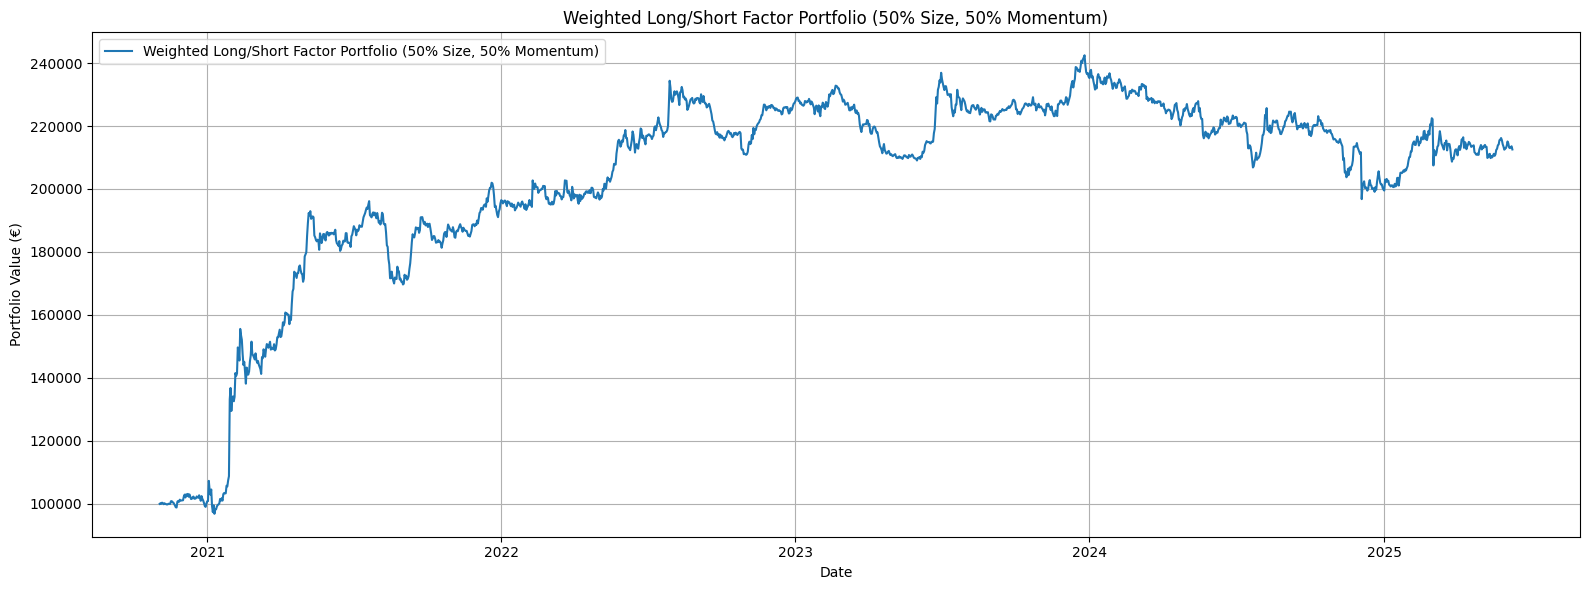


📈 Performance Summary:

Initial Capital                        100,000 €
Final Capital                          212,556 €
Total Return                            112.56 %
Annual Return (APY)                      17.81 %
Annual Volatility                        19.33 %
Sharpe Ratio                                0.84
Sortino Ratio                               1.38
Max Drawdown                            -18.86 %
Start Date             2020-11-03 00:00:00+00:00
End Date               2025-06-09 00:00:00+00:00
Days                                        1679
dtype: object


In [108]:
def build_weighted_combined_portfolio(size, mom, weight_size=0.7, weight_mom=0.3):
    df = pd.concat([size, mom], axis=1).dropna()
    weighted_portfolio = df.iloc[:, 0] * weight_size + df.iloc[:, 1] * weight_mom
    return weighted_portfolio.rename(f"CombinedFactor_{int(weight_size*100)}S_{int(weight_mom*100)}M")

# Performance plot
def plot_performance(series, title="", initial_capital=100_000):
    cum = (1 + series).cumprod() * initial_capital
    plt.figure(figsize=(16, 6))
    plt.plot(cum, label=title)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (€)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Performance metrics
def compute_performance_metrics(portfolio_returns, initial_capital=100_000, risk_free_rate=0.02):
    portfolio_returns = portfolio_returns.dropna()
    cum_curve = (1 + portfolio_returns).cumprod() * initial_capital
    total_days = (portfolio_returns.index[-1] - portfolio_returns.index[0]).days
    ann_return = (cum_curve.iloc[-1] / initial_capital) ** (365 / total_days) - 1
    ann_vol = portfolio_returns.std() * np.sqrt(365)
    excess_daily = portfolio_returns - risk_free_rate / 365
    sharpe = excess_daily.mean() / excess_daily.std() * np.sqrt(365)
    downside_std = portfolio_returns[portfolio_returns < 0].std()
    sortino = excess_daily.mean() / downside_std * np.sqrt(365) if downside_std > 0 else np.nan
    peak = cum_curve.cummax()
    drawdown = cum_curve / peak - 1
    max_dd = drawdown.min()

    return pd.Series({
        "Initial Capital": f"{initial_capital:,.0f} €",
        "Final Capital": f"{cum_curve.iloc[-1]:,.0f} €",
        "Total Return": f"{(cum_curve.iloc[-1]/initial_capital - 1)*100:.2f} %",
        "Annual Return (APY)": f"{ann_return*100:.2f} %",
        "Annual Volatility": f"{ann_vol*100:.2f} %",
        "Sharpe Ratio": round(sharpe, 2),
        "Sortino Ratio": round(sortino, 2),
        "Max Drawdown": f"{max_dd*100:.2f} %",
        "Start Date": portfolio_returns.index[0],
        "End Date": portfolio_returns.index[-1],
        "Days": total_days
    })

# Main execution
folder_path = "/content/drive/Shareddrives/Sixteen01-2025/Top 10 coins"
signal_window = 30
backtest_window = 30

# Load data
returns, price, market_cap, volatility = load_local_data(folder_path)

# Compute factors
size_factor = compute_size_factor_mcap(returns, market_cap, signal_window, backtest_window)
momentum_factor = compute_momentum_factor(returns, signal_window, backtest_window)

# Build weighted portfolio (% Size, % Momentum)
combined_portfolio = build_weighted_combined_portfolio(size_factor, momentum_factor, weight_size=0.5, weight_mom=0.5)

# Plot and metrics
plot_performance(combined_portfolio, title="Weighted Long/Short Factor Portfolio (50% Size, 50% Momentum)", initial_capital=100_000)
performance = compute_performance_metrics(combined_portfolio)
print("\n📈 Performance Summary:\n")
print(performance)


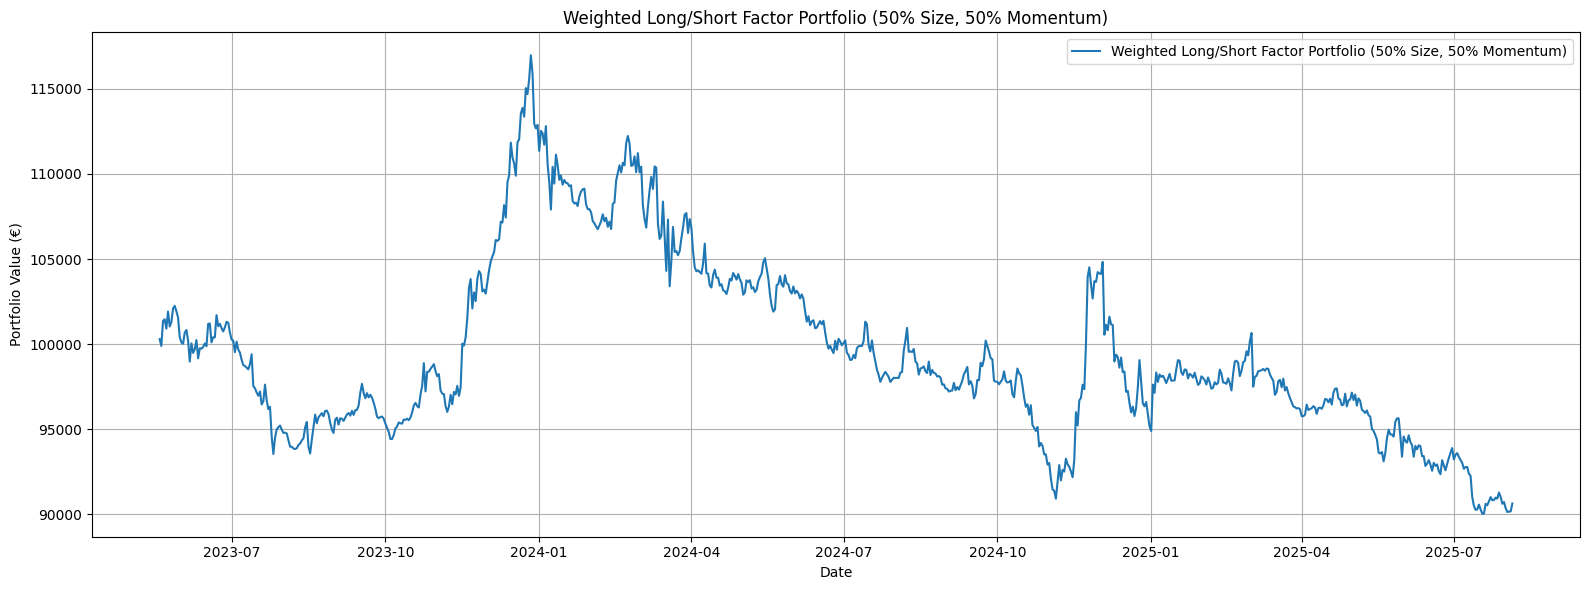


📈 Performance Summary:

Initial Capital                        100,000 €
Final Capital                           90,644 €
Total Return                             -9.36 %
Annual Return (APY)                      -4.34 %
Annual Volatility                        13.27 %
Sharpe Ratio                               -0.42
Sortino Ratio                              -0.58
Max Drawdown                            -23.03 %
Start Date             2023-05-19 00:00:00+00:00
End Date               2025-08-05 00:00:00+00:00
Days                                         809
dtype: object


In [109]:
# Main execution
folder_path = "/content/drive/Shareddrives/Sixteen01-2025/Data Factor Portfolio"
signal_window = 30
backtest_window = 30

# Load data
returns, price, market_cap, volatility = load_local_data(folder_path)

# Compute factors
size_factor = compute_size_factor_mcap(returns, market_cap, signal_window, backtest_window)
momentum_factor = compute_momentum_factor(returns, signal_window, backtest_window)

# Build weighted portfolio (% Size, % Momentum)
combined_portfolio = build_weighted_combined_portfolio(size_factor, momentum_factor, weight_size=0.5, weight_mom=0.5)

# Plot and metrics
plot_performance(combined_portfolio, title="Weighted Long/Short Factor Portfolio (50% Size, 50% Momentum)", initial_capital=100_000)
performance = compute_performance_metrics(combined_portfolio)
print("\n📈 Performance Summary:\n")
print(performance)